In [42]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

import plotly.express as px

from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error, r2_score

In [43]:
rates = pd.read_csv('data/Annual domestic sales and advertising of Lydia E Pinkham Medicine Comp.csv')
rates = rates.rename(columns={'Unnamed: 0': 'Time'})



data = rates.set_index('Time').sort_index()

In [44]:
print(data)

      sales  advertising
Time                    
1      1016          608
2       921          451
3       934          529
4       976          543
5       930          525
6      1052          549
7      1184          525
8      1089          578
9      1087          609
10     1154          504
11     1330          752
12     1980          613
13     2223          862
14     2203          866
15     2514         1016
16     2726         1360
17     3185         1482
18     3351         1608
19     3438         1800
20     2917         1941
21     2359         1229
22     2240         1373
23     2196         1611
24     2111         1568
25     1806          983
26     1644         1046
27     1814         1453
28     1770         1504
29     1518          807
30     1103          339
31     1266          562
32     1473          745
33     1423          749
34     1767          862
35     2161         1034
36     2336         1054
37     2602         1164
38     2518         1102


In [45]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from numpy import asarray

n_vars = 1 if type(data) is list else data.shape[1]
cols = list()
for i in range(1, 0, -1):
    cols.append(data.shift(i))
for i in range(0, 1):
    cols.append(data.shift(-i))

agg = pd.concat(cols, axis=1)
agg.dropna(inplace=True)
list_for_forecast = agg.values

len(list_for_forecast)

53

In [46]:
def decision_tree_forecast(train, testX):
    train = asarray(train)
    trainX, trainy = train[:, :-1], train[:, -1]

    model = DecisionTreeRegressor(random_state=0)    
    model.fit(trainX, trainy)

    yhat = model.predict([testX])
    return yhat[0]

def random_forest_forecast(train, testX):
    train = asarray(train)
    trainX, trainy = train[:, :-1], train[:, -1]

    model = RandomForestRegressor(n_estimators=1000)
    model.fit(trainX, trainy)
    
    yhat = model.predict([testX])
    return yhat[0]

In [47]:
predictions = list()
size = int(len(list_for_forecast) * 0.5)
train, test = list_for_forecast[0:size], list_for_forecast[size:len(list_for_forecast)]
history = [x for x in train]

for i in range(len(test)):
    testX, testy = test[i, :-1], test[i, -1]
    yhat = random_forest_forecast(history, testX)
    predictions.append(yhat)
    history.append(test[i])

error = mean_absolute_error(test[:, -1], predictions)
print("Random Forest error: ", error)

Random Forest error:  135.64911111111113


In [48]:
print("Random Forest metrics: ")
print("RMSE:", np.sqrt(mean_squared_error(test[:, -1], predictions)))
print("MAPE:", mean_absolute_percentage_error(test[:, -1], predictions))
print("MAE:", mean_absolute_error(test[:, -1], predictions))
print("R2: ", r2_score(test[:, -1], predictions))

Random Forest metrics: 
RMSE: 186.50639675575422
MAPE: 0.1739786764265914
MAE: 135.64911111111113
R2:  0.32144815065681576


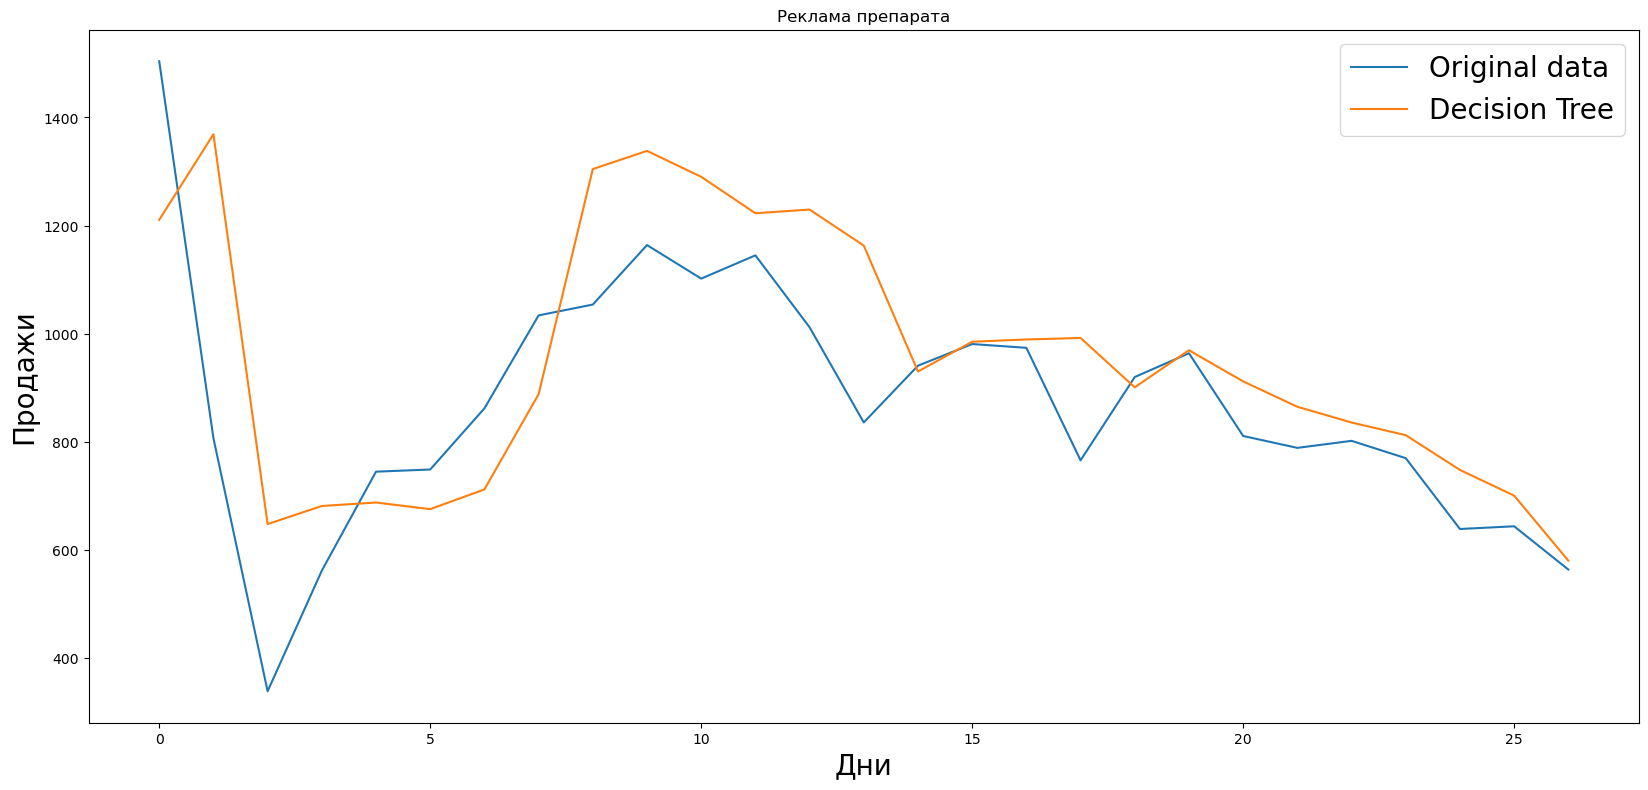

In [49]:
fig = plt.figure(figsize=(20, 9))

plt.plot(test[:, -1], label='Original data')
plt.plot(predictions, label='Decision Tree')

plt.legend(fontsize="20")
plt.title('Реклама препарата')
plt.ylabel('Продажи', fontsize="20")
plt.xlabel('Дни', fontsize="20")
plt.show()

In [50]:
predictions = list()
size = int(len(list_for_forecast) * 0.66)
train, test = list_for_forecast[0:size], list_for_forecast[size:len(list_for_forecast)]
history = [x for x in train]

for i in range(len(test)):
    testX, testy = test[i, :-1], test[i, -1]
    yhat = decision_tree_forecast(history, testX)
    predictions.append(yhat)
    history.append(test[i])

In [51]:
print("Decision Forest metrics: ")
print("RMSE:", np.sqrt(mean_squared_error(test[:, -1], predictions)))
print("MAPE:", mean_absolute_percentage_error(test[:, -1], predictions))
print("MAE:", mean_absolute_error(test[:, -1], predictions))
print("R2: ", r2_score(test[:, -1], predictions))

Decision Forest metrics: 
RMSE: 171.27755252805312
MAPE: 0.14004516918361626
MAE: 124.73684210526316
R2:  -0.03649962230970294


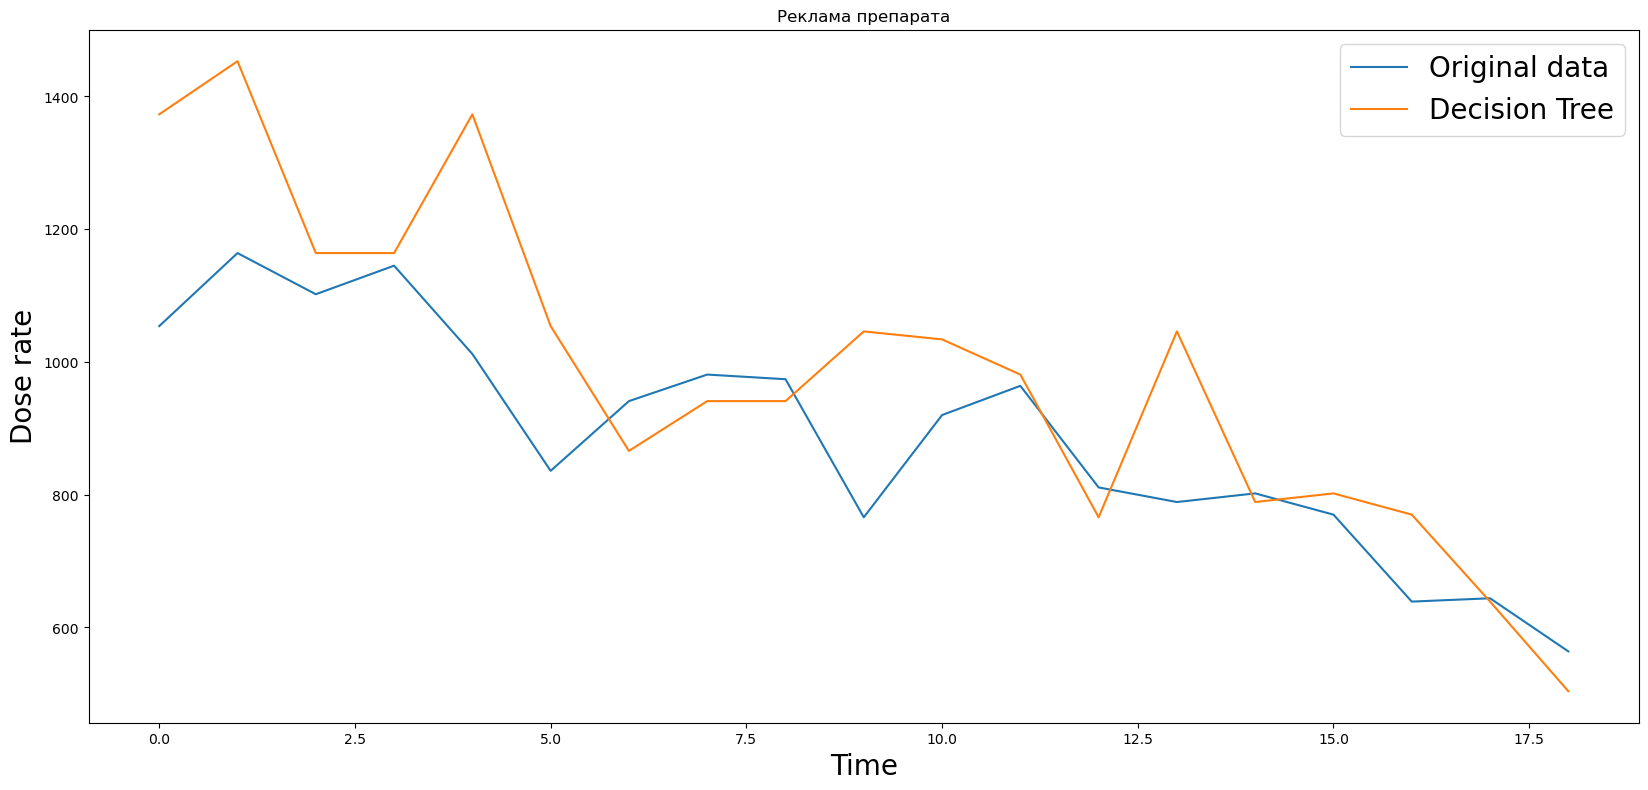

In [52]:
fig = plt.figure(figsize=(20, 9))

plt.plot(test[:, -1], label='Original data')
plt.plot(predictions, label='Decision Tree')

plt.legend(fontsize="20")
plt.title('Реклама препарата')
plt.ylabel('Dose rate', fontsize="20")
plt.xlabel('Time', fontsize="20")
plt.show()

In [53]:
from sklearn.ensemble import IsolationForest

model = IsolationForest(contamination=0.004)
model.fit(data[['sales']])

IsolationForest(contamination=0.004)

In [54]:
data['outliers'] = pd.Series(model.predict(data[['sales']])).apply(lambda x: 'yes' if (x == -1) else 'no' )
data.query('outliers=="yes"')

,sales,advertising,outliers
Time,,,
18,3351,1608,yes


In [55]:
fig = px.scatter(data.reset_index(), x='Time', y='sales', color='outliers')
fig.update_xaxes(
    rangeslider_visible=True,
)
fig.show()